In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Quantum mechanics

Time-independent Schroedinger equation reads
$$
\left[-\frac{\hbar^2}{2m} \frac{d^2 }{dx^2} + V(x)\right] \psi(x) = E \psi(x).
$$
Let us say we have boundary conditions $\psi(-L/2) = \psi(L/2) = 0$.

In the case of (an)harmonic oscillator we learned how to use the shooting method to find the eigenenergies by combining a root finder (bisection or secant method) with an ODE integrator (such as RK4).
This involved discretizing the space on a grid.

The problem can also be tackled by linear algebra methods.

## Matrix method for eigenenergies and eigenstates

By discretizing the space into $N$ intervals, we can represent the wave function $\psi(x)$ as an $N+1$-dimensional vector $\mathbf{\psi} = (\psi_0,\ldots,\psi_{N+1})$ such that

$$
\psi_k = \psi(x_k), \qquad x_k = -L/2 + k dx, \qquad dx = L/N.
$$

Due to boundary conditions we have $\psi_0 = \psi_{N+1} = 0$, thus effectively we deal with $N-1$-dimensional space.

Each operator becomes a $(N-1)$x$(N-1)$ matrix. By discretizing $\frac{d^2 }{dx^2}$ by the central difference we get

$$
\frac{d^2}{dx^2} \psi_n \approx \frac{\psi_{n+1} - 2\psi_n + \psi_{n-1}}{dx^2}.
$$

There, the Hamiltonian, has the following matrix representation

$$
H_{nm} = -\frac{\hbar^2}{2m} \left[ \delta_{m,n+1} \psi_{n+1} - 2 \delta_{m,n} \psi_{n} + \delta_{m,n-1} \psi_{n-1} \right] + \delta_{m,n} V(x_n),
$$

i.e. $H$ is a tridiagonal symmetric matrix.

Therefore finding the energies and wave function of the system corresponds to the matrix eigenvalue problem for the matrix $H$, i.e. we look for eigenstate $\psi$ and eigenenergies $E$ such that
$$
\sum_{m=1}^{N-1} H_{nm} \psi_m = E \psi_n
$$

Let us apply the method to (an)harmonic oscillator we had before.

In [2]:
# Constants
me = 9.1094e-31    # Mass of electron
hbar = 1.0546e-34  # Planck's constant over 2*pi
e = 1.6022e-19     # Electron charge
V0 = 50*e
a  = 1e-11
N = 1000
L = 20*a
dx = L/N

# Potential functions
def Vharm(x):
    return V0 * x**2 / a**2

def Vanharm(x):
    return V0 * x**4 / a**4

# Construct the Hamiltonian matrix
def HamiltonianMatrix(V):
    H = (-hbar**2 / (2*me*dx**2)) * (np.diag((N-2)*[1],-1) + np.diag((N-1)*[-2],0) + np.diag((N-2)*[1],1)) 
    H += np.diag([V(-0.5 * L + dx*(k+0.5)) for k in range(1,N)],0)
    return H

# Compute the normalisation factor with trapezoidal rule
def integral_psi2(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N):
        ret += psi[k] * np.conj(psi[k]) + psi[k+1] * np.conj(psi[k+1])
    
    ret *= 0.5 * dx
    
    return ret

# Compute the integral (to determine the sign)
def integral_psi(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N//2):
        ret += psi[k] + psi[k+1]
    
    ret *= 0.5 * dx
    
    return ret

Since our matrix is real symmetric, we can use a straightforward implementation of the QR algorithm.
We thus expect to obtain representation of $H$ in form
$$
H = Q^T A Q
$$
where $A$ is diagonal and contains the energies, while $Q$ is orthogonal and has eigenvectors (wave functions) in its columns.

In [3]:
# Simple implementation of the QR algorithm
# For real symmetric matrix we expect
# A to converge to diagonal matrix with eigenvalues
# and Q to have eigenvectors in each column
def eigen_qr_simple(A, iterations=100):
    Ak = np.copy(A)
    n = len(A[0])
    QQ = np.eye(n)
    for k in range(iterations):
        Q, R = np.linalg.qr(Ak)
        Ak = np.dot(R,Q)
        QQ = np.dot(QQ,Q)
    return Ak, QQ


Using simple QR decomposition
First 10 eigenenergies of Harmonic oscillator are
E_ 0 = 138.0227220181584 eV
E_ 1 = 414.0656659872072 eV
E_ 2 = 690.1036097526343 eV
E_ 3 = 966.136554028328 eV
E_ 4 = 1242.1646545118429 eV
E_ 5 = 1518.1925691076508 eV
E_ 6 = 1794.264990851771 eV
E_ 7 = 2070.579770340522 eV
E_ 8 = 2347.6427052950403 eV
E_ 9 = 2626.3110902945514 eV


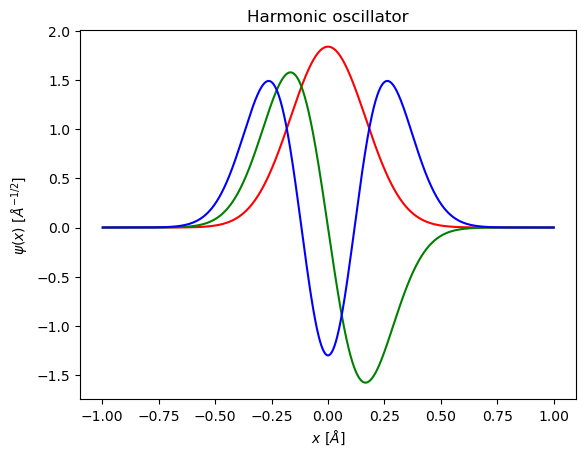

CPU times: user 47.6 s, sys: 3.01 s, total: 50.6 s
Wall time: 4.37 s


In [4]:
%%time

print("Using simple QR decomposition")
# Harmonic oscillator
Vpot = Vharm
Vlabel = "Harmonic oscillator"
A, Q = eigen_qr_simple(HamiltonianMatrix(Vpot),50)
indices = np.argsort(np.diag(A))
eigenvalues = np.diag(A)[indices]
eigenvectors = [Q[:,indices[i]] for i in range(len(indices))]
Nprint = 10
print("First",Nprint,"eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_",n,"=",eigenvalues[n]/e,"eV")

Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[i], dx)
    sign = 1
    if (integral_psi(eigenvectors[i], dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1.e-5*sign*eigenvectors[i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.show()

First 10 eigenenergies of Anharmonic oscillator are
E_ 0 = 205.3022520064578 eV
E_ 1 = 735.6578481328587 eV
E_ 2 = 1443.4564627068437 eV
E_ 3 = 2254.386094620506 eV
E_ 4 = 3148.0999787331502 eV
E_ 5 = 4111.305594420894 eV
E_ 6 = 5135.101294752596 eV
E_ 7 = 6213.029170837947 eV
E_ 8 = 7340.383787818462 eV
E_ 9 = 8514.323805747972 eV


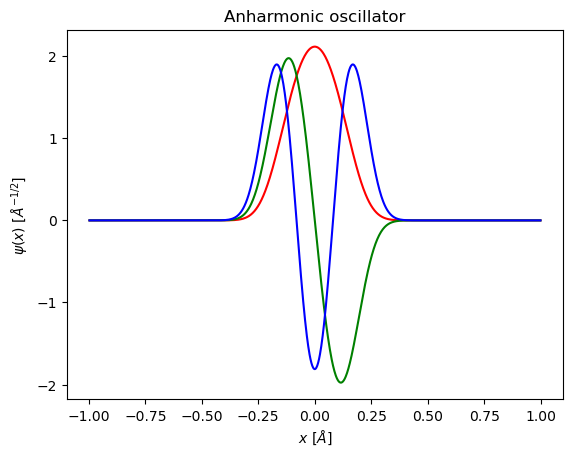

CPU times: user 48.2 s, sys: 1.56 s, total: 49.8 s
Wall time: 4.29 s


In [5]:
%%time
# Anharmonic oscillator
Vpot = Vanharm
Vlabel = "Anharmonic oscillator"
A, Q = eigen_qr_simple(HamiltonianMatrix(Vpot),50)
indices = np.argsort(np.diag(A))
eigenvalues = np.diag(A)[indices]
eigenvectors = [Q[:,indices[i]] for i in range(len(indices))]
Nprint = 10
print("First",Nprint,"eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_",n,"=",eigenvalues[n]/e,"eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[i], dx)
    sign = 1
    if (integral_psi(eigenvectors[i], dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.title(Vlabel)
    plt.plot(xpoints,1.e-5*sign*eigenvectors[i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.show()

We can also use efficient implementations of the eigenvalues/eigenvectors computation in numpy.

First 10 eigenenergies of Harmonic oscillator are
E_ 0 = 138.02272201836868 eV
E_ 1 = 414.06566598705024 eV
E_ 2 = 690.1036097525814 eV
E_ 3 = 966.1365531952405 eV
E_ 4 = 1242.1644964182658 eV
E_ 5 = 1518.1874420733782 eV
E_ 6 = 1794.2054159307145 eV
E_ 7 = 2070.218614797808 eV
E_ 8 = 2346.22828283367 eV
E_ 9 = 2622.2410166168474 eV
CPU times: user 1.6 s, sys: 232 ms, total: 1.83 s
Wall time: 176 ms


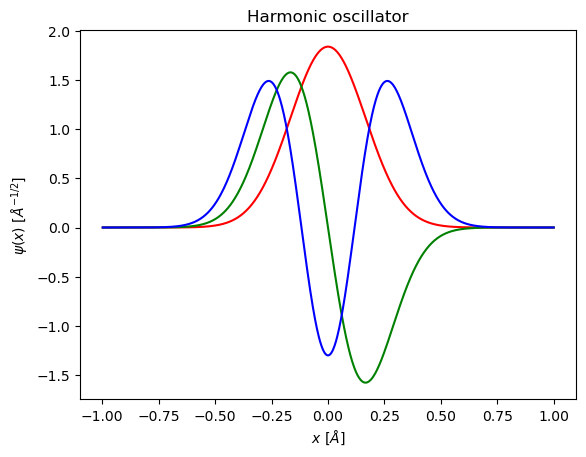

In [6]:
%%time
Vpot = Vharm
Vlabel = "Harmonic oscillator"
eigenvalues, eigenvectors = np.linalg.eigh(HamiltonianMatrix(Vpot))
Nprint = 10
print("First",Nprint,"eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_",n,"=",eigenvalues[n]/e,"eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[:,i], dx)
    sign = 1
    if (integral_psi(eigenvectors[:,i],dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1e-5*sign*eigenvectors[:,i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])

First 10 eigenenergies of Anharmonic oscillator are
E_ 0 = 205.30225200542532 eV
E_ 1 = 735.657848132775 eV
E_ 2 = 1443.4564627073673 eV
E_ 3 = 2254.3860946191503 eV
E_ 4 = 3148.0999776542703 eV
E_ 5 = 4111.305458998604 eV
E_ 6 = 5135.096902970586 eV
E_ 7 = 6212.968932992062 eV
E_ 8 = 7339.921656901498 eV
E_ 9 = 8511.968121936385 eV
CPU times: user 1.6 s, sys: 255 ms, total: 1.86 s
Wall time: 181 ms


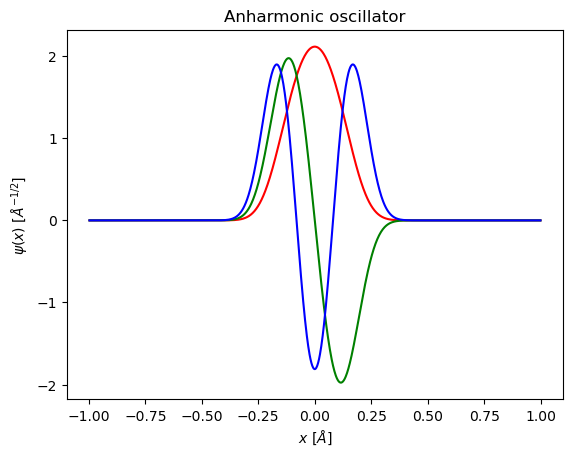

In [7]:
%%time
Vpot = Vanharm
Vlabel = "Anharmonic oscillator"
eigenvalues, eigenvectors = np.linalg.eigh(HamiltonianMatrix(Vpot))
Nprint = 10
print("First",Nprint,"eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_",n,"=",eigenvalues[n]/e,"eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[:,i], dx)
    sign = 1
    if (integral_psi(eigenvectors[:,i],dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1e-5*sign*eigenvectors[:,i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])

## Time evolution of free particle wave function

*Exercise 9.8 from M. Newman, Computational Physics*

The time-dependent Schroedinger equation reads

$$
\hat{H} \psi = i \hbar \frac{\partial \psi}{\partial t}~.
$$

e.g. for a free particle it reads

$$
-\frac{\hbar^2}{2m} \frac{\partial^2 \psi}{\partial x^2} = i \hbar \frac{\partial \psi}{\partial t}~.
$$

Formal solution be written as

$$
\psi(t) = e^{-\frac{it}{\hbar} \hat{H}} \psi(0),
$$

with $\hat{U}(t) =  e^{-\frac{it}{\hbar} \hat{H}}$ being the time evolution operator.
It is a unitary operator $U^\dagger U = \hat{I}$, therefore, the norm of the wave function $|\psi|^2$ is conserved.

We can study time evolution by succesively applying approximate $\hat{U}(\Delta t)$ over small time intervals.

- FTCS scheme
$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx 1 - \frac{i \Delta t}{\hbar} \hat{H}
$$
Such an operator is not unitary since
$$
U^\dagger (\Delta t) = 1 + \frac{i \Delta t}{\hbar} \hat{H} \neq \hat{U}(\Delta t).
$$
If $U$ is applied to an energy eigenstate $\psi_l$, such that $\hat{H} \psi_l = E_k \psi_l$, we get
$$
\psi_l(N \Delta t) = \lambda_l^N \psi_l(0),
$$
where $\lambda_l = \left[1 - \frac{i \Delta t E_l}{\hbar} \right]$.
Since $|\lambda_l| > 1$, the method is unstable.

- Implicit scheme

We apply the approximation of the FTCS scheme to the inverse of $\hat{U}(\Delta t)$.
This implies
$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx \frac{1}{1 + \frac{i \Delta t}{\hbar} \hat{H}}.
$$
The operator is also non-unitary. The method is stable because
$$
|\lambda_l| = \left| \frac{1}{1 + \frac{i \Delta t}{\hbar} E_L} \right| < 1,
$$
but the method does not conserve the norm of the wave function.

- Crank-Nicholson scheme

Crank-Nicholson scheme takes the combitation of FTCS and implicit schemes.
This correspons to a rational approximation of $\hat{U}(\Delta t)$:
$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx \frac{1 - \frac{i \Delta t}{\hbar} \hat{H}}{1 + \frac{i \Delta t}{\hbar} \hat{H}}.
$$

This operator is unitary (for an hermitian $\hat{H}$), $U^\dagger U = U U^\dagger$, and conserves the norm of the wave function.

Let us consider the particle in a box of length $L$.
We thus have boundary conditions $\psi(0) = \psi(L) = 0$.

Given some initial wave function $\psi(x)$, we can numerically integrate the Schroedinger equation to study the time evolution of the wave function.

Let us write the equation in a form:
$$
\frac{\partial \psi}{\partial t} = \frac{i \hbar}{2m} \frac{\partial^2 \psi}{\partial x^2}.
$$
We can now use the central difference approximation for $\partial^2 \psi / \partial x^2$:
$$
\frac{\partial \psi}{\partial t} \approx \frac{i \hbar}{2ma^2} \left[ \psi(x+a,t) - 2 \psi(x,t) + \psi(x-a,t) \right].
$$

This gives us discretized wave function in coordinate space, in full analogy to the heat equation that we studied before. The only difference is that now we are dealing with complex-valued functions.

We now need to apply the prescription for time evolution.
The options are:
- FTCS scheme
$$
\psi(x,t+h) = \psi(x,t) + h \frac{i \hbar}{2ma^2} \left[ \psi(x+a,t) - 2 \psi(x,t) + \psi(x-a,t) \right],
$$
or
$$
\psi^{n+1}_k = \psi^n_k + h \frac{i \hbar}{2ma^2} (\psi^n_{k+1} - 2 \psi^n_k + \psi^n_{k-1}).
$$
- Implicit scheme
$$
\psi^{n+1}_k = \psi^n_k + h \frac{i \hbar}{2ma^2} (\psi^{n+1}_{k+1} - 2 \psi^{n+1}_k + \psi^{n+1}_{k-1}).
$$
- Crank-Nicholson scheme
$$
\psi^{n+1}_k = \psi^n_k + \frac{h}{2} \frac{i \hbar}{2ma^2} (\psi^n_{k+1} - 2 \psi^n_k + \psi^n_{k-1}) + \frac{h}{2} \frac{i \hbar}{2ma^2} (\psi^{n+1}_{k+1} - 2 \psi^{n+1}_k + \psi^{n+1}_{k-1}).
$$

To preserve unitarity it makes sense to apply Crank-Nicholson scheme.
In this case we need to solve the tridiagonal system of equations at each time step.

In [8]:
import numpy as np

# Solve tridiagonal system of linear equations
#  d: vector of diagonal elements
#  l: vector of elements on the lower subdiagonal
#  u: vector of elements on the upper superdiagonal
# v0: right-hand-side vector
def linsolve_tridiagonal(d, l, u, v0):
    # Initialization
    N = len(v0)
    a = d.copy() # Current diagonal elements
    b = u.copy() # Current upper diagonal elements
    v = v0.copy()
    
    # Gaussian elimination
    for r in range(N):
        if (a[r] == 0.):
            print("Diagonal element is zero! Cannot solve the tridiagonal system with simple Gaussian elimination")
            return None
        b[r] /= a[r]
        v[r] /= a[r]
        a[r] = 1.
        if (r < N - 1):
            a[r + 1] -= l[r+1] * b[r]
            v[r + 1] -= l[r+1] * v[r]
            
    # Backsubstitution
    x = np.empty(N,dtype=np.cdouble)
    
    x[N - 1] = v[N - 1]
    for r in range(N-2,-1,-1):
        x[r] = v[r] - b[r] * x[r + 1]
            
    return x

In [9]:
me   = 9.1094e-31  # Mass of electron in kg
hbar = 1.0546e-34  # Planck's constant over 2*pi

# Single Crank-Nicholson scheme iteration for the Schroedinger equation
# psi is a complex-valued wave function discretized in space
# r = i * h * hbar / (2*m*a^2)
# scheme: 0 - FTCS, 1 - implicit, 2 - Crank-Nicholson
def schrodinger_finitediff_iteration(psi, r, scheme = 2):
    N = len(psi) - 1
    
    psinew = np.empty_like(psi, dtype=np.cdouble)
    
    # Boundary conditions
    psinew[0] = psi[0]
    psinew[N] = psi[N]
    
    if (scheme == 0):
        for i in range(1,N):
            psinew[i] = psi[i] + r * (psi[i+1] - 2 * psi[i] + psi[i-1])
    elif (scheme == 1):
        d  = np.full(N-1, 1 + 2*r)
        ud = np.full(N-1, -r)
        ld = np.full(N-1, -r)

        # Implicit scheme matrix
        v = np.array(psi[1:N])
        v[0]   += r * psi[0]
        v[N-2] += r * psi[N]

        # Solve tridiagonal system
        psinew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    else:
        d  = np.full(N-1, 2*(1+r))
        ud = np.full(N-1, -r)
        ld = np.full(N-1, -r)

        # Crank-Nicolson explicit step
        v = psi[1:N]*2*(1-r) + psi[:-2]*r + psi[2:]*r
        v[0]   += r * psi[0]
        v[N-2] += r * psi[N]

        # Solve tridiagonal system
        psinew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    
    return psinew

def schrodinger_finitediff_solve(psi0, h, nsteps, a, m = me, scheme = 2):
    psi = psi0.copy()
    r = 1j * h * hbar / (2 * m * a**2)
    for i in range(nsteps):
        psi = schrodinger_finitediff_iteration(psi, r, scheme)
        
    return psi


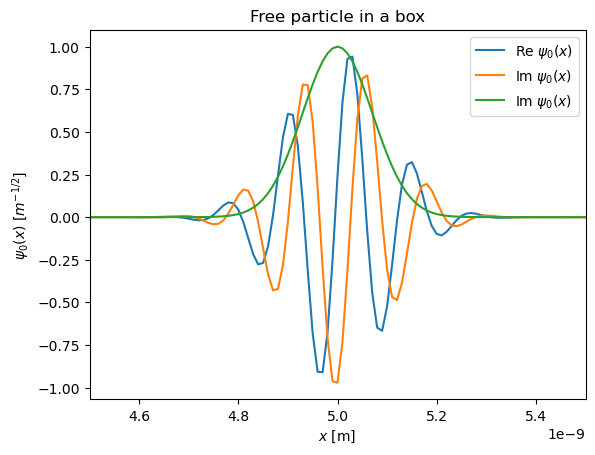

In [14]:
L = 1e-8 # m
x0 = L / 2.
sig = 1e-10 # m
kappa = 5e10 # m^-1

N = 1000
dx = L / N

def psi0(x):
    return np.exp(-(x-x0)**2/(2*sig**2))*np.exp(1j*kappa*x)

psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

norm0 = integral_psi2(psi, dx)

import matplotlib.pyplot as plt
plt.title("Free particle in a box")
plt.xlabel('${x}$ [m]')
plt.ylabel('${\psi_0(x)}~[m^{-1/2}]}$')
plt.xlim(L/2 - 0.05*L,L/2 + 0.05*L)
plt.plot([dx*k for k in range(N+1)], np.real(psi), label="Re ${\psi_0(x)}$")
plt.plot([dx*k for k in range(N+1)], np.imag(psi), label="Im ${\psi_0(x)}$")
plt.plot([dx*k for k in range(N+1)], np.abs(psi)**2, label="Im ${\psi_0(x)}$")
plt.legend()
plt.show()

Now integrate over time

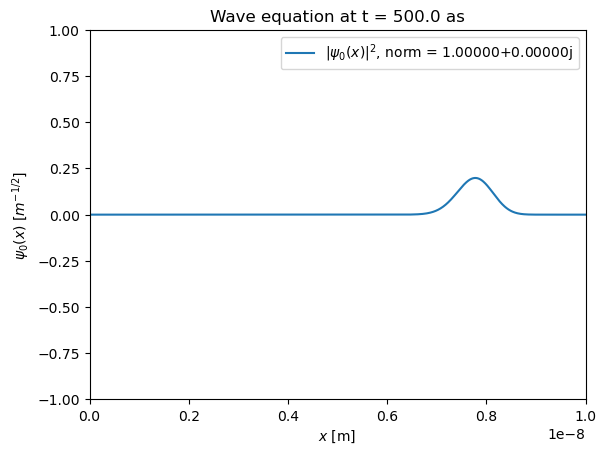

In [15]:
from IPython.display import clear_output
import time

current_time = 0.
h = 1e-18
nsteps = 10
for i in range(50):
    psi = schrodinger_finitediff_solve(psi, h, nsteps, dx, me, 2)
    current_time += h * nsteps
    
    clear_output(wait=True)
    plt.title("Wave equation at t = " + '{:.1f}'.format(current_time*1.e18) + " as")
    plt.xlabel('${x}$ [m]')
    plt.ylabel('${\psi_0(x)}~[m^{-1/2}]}$')
    plt.xlim(0,L)
    plt.ylim(-1,1)
    # plt.xlim(L/2 - 0.05*L,L/2 + 0.05*L)
    #plt.plot([a*k for k in range(N+1)], np.real(psi), label="Re ${\psi_0(x)}$")
    #plt.plot([a*k for k in range(N+1)], np.imag(psi), label="Im ${\psi_0(x)}$")
    plt.plot([a*k for k in range(N+1)], np.abs(psi)**2, label="${|\psi_0(x)}|^2$, norm = " + '{:.5f}'.format(integral_psi2(psi,dx)/norm0))
    plt.legend()
    plt.show()